# Perform linear mixed-model regresion on comprehension point.

In [30]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector, FactorVector, globalenv
from sklearn.linear_model import LogisticRegression
from scipy.stats import gaussian_kde

In [31]:
# Call R
lme4 = importr('lme4')
base = importr('base')
stats = importr('stats')
lmerTest = importr('lmerTest')

### Load data.

In [32]:
# File
previous, current = os.path.split(os.getcwd())
dname = previous[0:-5] 
fname_words = dname +'\\data\\all_subjects_words_GPT2_big.pkl'
fname_sentences = dname +'\\data\\all_subjects_sentences_GPT2_big.pkl'


# Dump information to that file
df_words = pickle.load(open(fname_words, 'rb'))
df_sentences = pickle.load(open(fname_sentences, 'rb'))

### Define threshold.

In [33]:
p_threshold = 0.75

### Extract comprehension point.

In [34]:
for df, weight, vmin, vmax in zip((df_words, df_sentences), 
                                  (1, 7), 
                                  (0.5, 1.5), 
                                  (12, 5.5)):
    
    # Declare dataFrame
    n_sujs, n_trials, n_vitesses = df['score'].shape    
    isolation_points = np.full((n_sujs, n_trials), np.nan)
    
    # Loop across sujs and trials
    for i, suj in enumerate(np.unique(df['suj'])):
        for j, trial in enumerate(np.arange(n_trials)):
            
            # Get variables
            Y = df['score'][i, j]
            X = df['vitesse'][i, j]
            
            # Sort variables
            idx_sort = np.argsort(X)
            X = X[idx_sort]
            Y = Y[idx_sort]
            
            # Append "0th gate" and "N+1 gate"
            X = np.r_[vmin, X, vmax]
            Y = np.r_[1, Y, 0]
            
            # Prepare for R
            globalenv["score"] = FloatVector(Y)
            globalenv["vitesse"] = FloatVector(X)
            globalenv["weight"] = FloatVector(np.ones(X.size) * weight)
            
            # Fit logistic regression
            m = stats.glm("score ~ vitesse", weight=globalenv["weight"], family='binomial')
            b, a = base.summary(m)[-6][:2]

            # Extract x value at p_threshold
            isolation_point = (np.log(p_threshold/(1 - p_threshold)) - b) / a
            isolation_points[i, j] = isolation_point
            
            # Remove non-sense values (happens very rarely)
            if isolation_point < 0 or isolation_point > 20:
                isolation_points[i, j] = np.nan
    
    # Add isolation point to dataFrame
    df['isolation_point'] = isolation_points

### Prepare data for R and fit LMM.

We take only one value for each trial (not all "vitesses"). \
This value is not a "rate" but a "rate at no compression". 

In [35]:
#  " + scale(phir_rate, center = TRUE, scale = TRUE)" + \

lmms = []
for i, df in enumerate((df_words, df_sentences)):
    
    # Declare variables in R environment
    globalenv["isolation_point"] = FloatVector(df['isolation_point'].ravel())
    globalenv["suj"] = FactorVector(np.array(df['suj'][:, :, 0], dtype=np.str).ravel())
    globalenv["syll_rate"] = FloatVector(df['syll_rate'][:, :, 0].ravel() / df['vitesse'][:, :, 0].ravel())
    globalenv["phon_rate"] = FloatVector(df['phon_rate'][:, :, 0].ravel() / df['vitesse'][:, :, 0].ravel())
    globalenv["syir_rate"] = FloatVector(df['syir_rate'][:, :, 0].ravel() / df['vitesse'][:, :, 0].ravel())
    globalenv["phir_rate"] = FloatVector(df['phir_rate'][:, :, 0].ravel() / df['vitesse'][:, :, 0].ravel())
    globalenv["stat_surp"] = FloatVector(df['stat_surp'][:, :, 0].ravel()/ df['vitesse'][:, :, 0].ravel())
    globalenv["ctxt_surp_BERT"] = FloatVector(df['ctxt_surp_BERT'][:, :, 0].ravel() / df['vitesse'][:, :, 0].ravel())
    globalenv["ctxt_surp_GPT2_big"] = FloatVector(df['ctxt_surp_GPT2_big'][:, :, 0].ravel() / df['vitesse'][:, :, 0].ravel())
    globalenv["peak_env"] = FloatVector(df['peak_env'][:, :, 0].ravel() / df['vitesse'][:, :, 0].ravel())

     # " + scale(ctxt_surp_GPT2_big, center = TRUE, scale = TRUE)" + \

    # Fit LMM
    if i == 0:
        formula = "isolation_point ~ scale(phon_rate, center = TRUE, scale = TRUE)" + \
        " + scale(syll_rate, center = TRUE, scale = TRUE)" + \
        " + scale(syir_rate, center = TRUE, scale = TRUE)" + \
        " + scale(stat_surp, center = TRUE, scale = TRUE)" + \
        " + scale(peak_env, center = TRUE, scale = TRUE)" + \
        " + (1|suj)"
    if i == 1:
        formula = "isolation_point ~ scale(phon_rate, center = TRUE, scale = TRUE)" + \
        " + scale(syll_rate, center = TRUE, scale = TRUE)" + \
        " + scale(phir_rate, center = TRUE, scale = TRUE)" + \
        " + scale(syir_rate, center = TRUE, scale = TRUE)" + \
        " + scale(stat_surp, center = TRUE, scale = TRUE)" + \
        " + scale(ctxt_surp_BERT, center = TRUE, scale = TRUE)" + \
        " + scale(peak_env, center = TRUE, scale = TRUE)" + \
        " + (1|suj)"
    m = lmerTest.lmer(formula)
    lmms.append(m)

### Print GLMM.

In [36]:
# Words
print(base.summary(lmms[0]))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"isolation_point ~ scale(phon_rate, center = TRUE, scale = TRUE) + scale(syll_rate, center = TRUE, scale = TRUE) + scale(syir_rate, center = TRUE, scale = TRUE) + scale(stat_surp, center = TRUE, scale = TRUE) + scale(peak_env, center = TRUE, scale = TRUE) + (1|suj)"

REML criterion at convergence: 22376

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1107 -0.6495 -0.1887  0.4058  4.0336 

Random effects:
 Groups   Name        Variance Std.Dev.
 suj      (Intercept) 0.1797   0.4239  
 Residual             4.0953   2.0237  
Number of obs: 5250, groups:  suj, 21

Fixed effects:
                                                Estimate Std. Error         df
(Intercept)                                      3.91519    0.09662   19.99411
scale(phon_rate, center = TRUE, scale = TRUE)   -0.07159    0.02825 5224.01424
scale(syll_rate, center = TRUE, scale = TRUE)   -0.22191    0.02828 5

In [37]:
# Sentences
print(base.summary(lmms[1]))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"isolation_point ~ scale(phon_rate, center = TRUE, scale = TRUE) + scale(syll_rate, center = TRUE, scale = TRUE) + scale(phir_rate, center = TRUE, scale = TRUE) + scale(syir_rate, center = TRUE, scale = TRUE) + scale(stat_surp, center = TRUE, scale = TRUE) + scale(ctxt_surp_BERT, center = TRUE, scale = TRUE) + scale(peak_env, center = TRUE, scale = TRUE) + (1|suj)"

REML criterion at convergence: 3170

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.0653 -0.6319 -0.0219  0.6308  4.2453 

Random effects:
 Groups   Name        Variance Std.Dev.
 suj      (Intercept) 0.02279  0.1510  
 Residual             0.25315  0.5031  
Number of obs: 2100, groups:  suj, 21

Fixed effects:
                                                     Estimate Std. Error
(Intercept)                                         3.226e+00  3.473e-02
scale(phon_rate, center = TRUE, scale = TRUE)      -2.591e-0

### Plot Figure 5.

In [38]:
variable_names = [
    r'Phonemic rate',
     r'Phonemic information',
    r'Static lexical surprise',
    r'Syllabic rate',#'Phonemic information rate (%/s)',
    r'Syllabic information', #'Syllabic information rate (%/s)', 
    r'Contextual lexical surprise'
]
xlabels = [
    'Rate ($s^{-1}$)',  
    'Surprise rate ($bit.s^{-1}$)', 
    'Surprise rate ($bit.s^{-1}$)',
    'Rate ($s^{-1}$)', 
    'Surprise rate ($bit.s^{-1}$)',
    'Surprise rate ($bit.s^{-1}$)',
]
var_names = [
    'phon_rate',
     'phir_rate',
    'stat_surp', 
    'syll_rate',
    'syir_rate',
    'ctxt_surp_BERT'
]
xlims = [[0, 80],[0, 10] , [0, 150],[0, 40], [0, 20], [0, 20]]
colors = ['#e41a1c','#efca08','#377eb8','#ff7f00', '#4daf4a', 'darkorchid']
alphas = [0.2, 0.6]
labels = ['Words', 'Sentences']

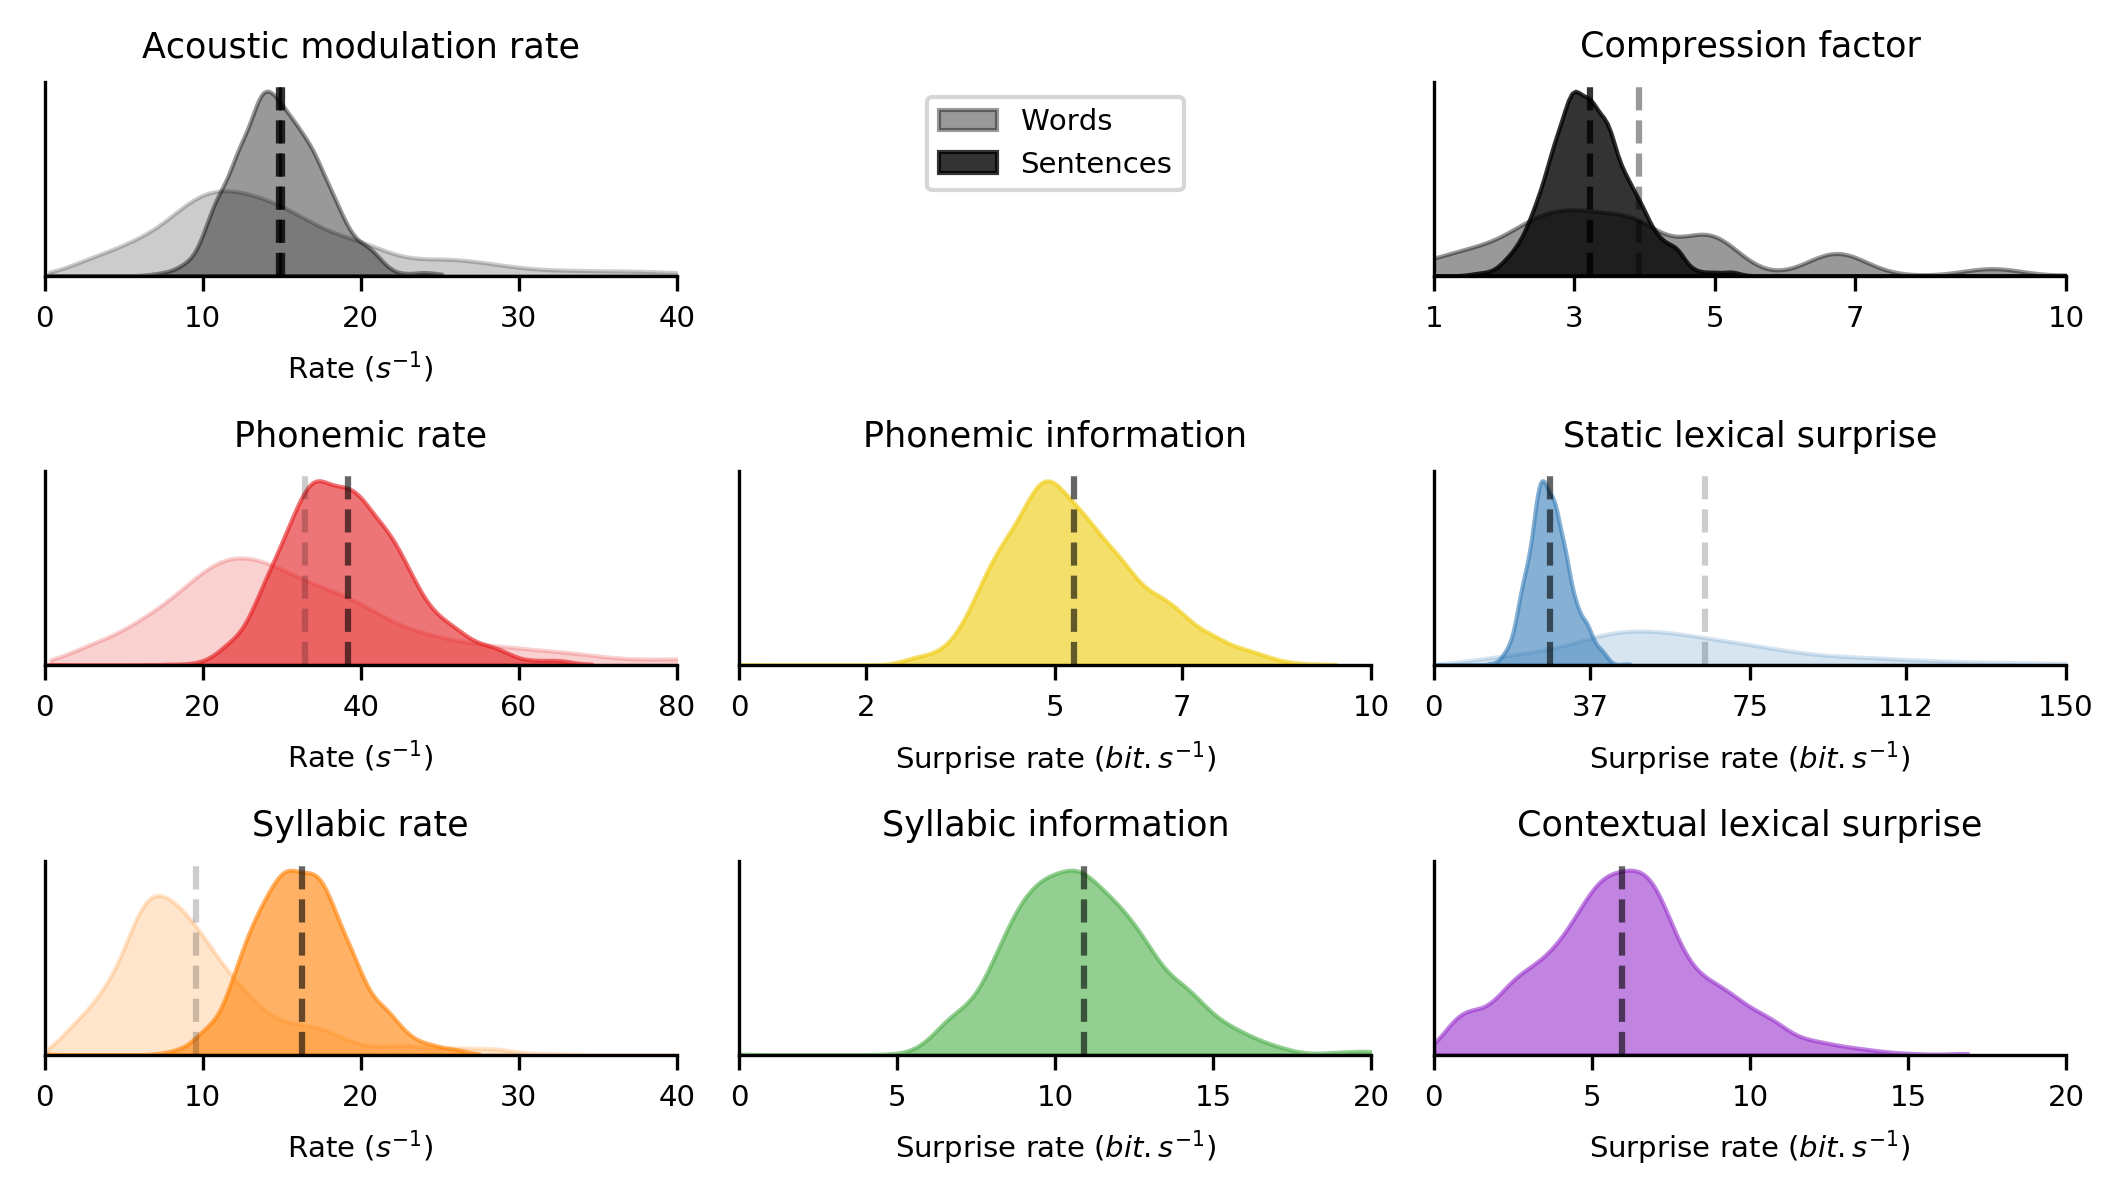

In [39]:
# You can run it twice as well :)

fig, axs = plt.subplots(3, 3, figsize=(7.09, 4), facecolor='w', dpi=300)
plt.rcParams["font.size"] = "7"

####### Plot distribution of isolation point  ########
    
# Compression Rate    
# Short name for axis
ax0 = axs.ravel()[2]
for (df, alpha, label) in zip((df_words, df_sentences), [0.4, .8], labels):
    # Compute density
    x = df['isolation_point'].ravel()
    density = gaussian_kde(x[np.logical_not(np.isnan(x))])
    xs = np.linspace(0, 10, 200)
    density.covariance_factor = lambda : .2
    density._compute_covariance()
    # Plot
    ax0.fill_between(xs, density(xs), color='k', alpha=alpha, label=label)
    # Mean
    m = np.nanmean(df['isolation_point'].ravel())
    ax0.axvline(m, color='k', linestyle='--', alpha=alpha)
# Remove frame
ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
# Global aesthetics
ax0.set_title('Compression factor')
#ax0.set_xlabel('Compression')
ax0.set_xlim(1, 10)
ax0.set_xticks(np.linspace(1,10, num=5, dtype=np.int32))
ax0.set_ylim(0, None)
ax0.set_yticks([])
# ax2.legend(box_to_anchor=(0.7, 0.9))


# legend only
ax2 = axs.ravel()[1]
lines, labels = ax0.get_legend_handles_labels()   
ax2.legend(lines, labels, loc = 'upper center')
axs.ravel()[1].set_axis_off()



# Acoustic modulation Rate
xlim = [0, 40]
# Short name for axis
ax1 = axs.ravel()[0]
# Compute density
vitesse_at_isolation = df_sentences['isolation_point'].ravel()
x = df_sentences['peak_env'][:, :, 0].ravel() / df_sentences['vitesse'][:, :, 0].ravel() * vitesse_at_isolation
density = gaussian_kde(x[np.logical_not(np.isnan(x))])
xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
density.covariance_factor = lambda : .2
density._compute_covariance()
# Plot
ax1.fill_between(xs, density(xs), color='k', alpha=0.4)
# Mean
ax1.axvline(np.nanmean(x), color='k', linestyle='--', alpha=alpha)

# Compute density the return
vitesse_at_isolation = df_words['isolation_point'].ravel()
x = df_words['peak_env'][:, :, 0].ravel() / df_words['vitesse'][:, :, 0].ravel() * vitesse_at_isolation
density = gaussian_kde(x[np.logical_not(np.isnan(x))])
xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
density.covariance_factor = lambda : .2
density._compute_covariance()
# Plot
ax1.fill_between(xs, density(xs), color='k', alpha=0.2)
# Mean
ax1.axvline(np.nanmean(x), color='k', linestyle='--', alpha=alpha)

# Remove frame
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

# Global aesthetics
ax1.set_title('Acoustic modulation rate')
ax1.set_xlabel('Rate ($s^{-1}$)')
ax1.set_xlim(xlim)
ax1.set_ylim(0, None)
ax1.set_yticks([])
ax1.set_xticks(np.linspace(xlim[0],xlim[-1], num=5, dtype=np.int32))



############ Plot densities of all variables ##############
hugee = []
for i, (ax, var_name, variable_name, xlabel, color, xlim) in enumerate(zip(axs.ravel()[3:],
                                                                   var_names, 
                                                                   variable_names,
                                                                   xlabels,
                                                                   colors,
                                                                   xlims)):

    for j, (df, alpha, label) in enumerate(zip((df_words, df_sentences), alphas, labels)):

        # Pass if dataset is isolated words (no ctxt_surp)
        if i == 1 and j == 0: continue
        if i == 5 and j == 0: continue
        if i == 4 and j == 0: continue
        
        # Compute density
        vitesse_at_isolation = df['isolation_point'].ravel()
        x = df[var_name][:, :, 0].ravel() / df['vitesse'][:, :, 0].ravel() * vitesse_at_isolation
        density = gaussian_kde(x[np.logical_not(np.isnan(x))])
        xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
        density.covariance_factor = lambda : .2
        density._compute_covariance()

        # Plot
        ax.fill_between(xs, density(xs), color=color, alpha=alpha)

        # Mean
        ax.axvline(np.nanmean(x), color='k', linestyle='--', alpha=alpha)
        hugee.append([var_name,x])
    # Global aesthetics
    ax.set_title(variable_name)
    ax.set_xlabel(xlabel)
    ax.set_xlim(xlim)
    ax.set_ylim(0, None)
    ax.set_yticks([])
    ax.set_xticks(np.linspace(xlim[0],xlim[-1], num=5, dtype=np.int32))

    # Remove frame
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

plt.tight_layout(w_pad=1)

In [15]:
#fig.savefig(dname+"\\figures\\Figure_5.png", dpi=300, bbox_inches='tight')